In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_

import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import random

import pickle

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# For CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Make results deterministic (may slow down some GPU operations)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cpu


In [ ]:


nltk.download('punkt_tab')

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn/rnn_impl/Tweets.csv')
print(df['airline_sentiment'].value_counts())

df = df[['text', 'airline_sentiment']].dropna()
print(df.shape)
# Enhanced text preprocessing
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].apply(clean_text)

df = df.drop_duplicates('text').dropna()
df.shape

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64
(14640, 2)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(14170, 2)

In [ ]:
# Label encoding
le = LabelEncoder()
df = df[df['airline_sentiment'] != 'neutral']
df['label'] = le.fit_transform(df['airline_sentiment'])
class_counts = df['label'].value_counts().sort_index()
total = class_counts.sum()
class_weights = total / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float)
print("Class weights:", class_weights_tensor)

#if gpu move weights to device locally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

df['tokens'] = df['text'].apply(word_tokenize)

# filtered vocabulary (frequency-based)
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Filter vocabulary - keep words with frequency >= 3
min_freq = 3
filtered_vocab = {word: count for word, count in word_counts.items() if count >= min_freq}
vocab = {word: i+2 for i, word in enumerate(filtered_vocab.keys())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print(f"Original vocabulary size: {len(word_counts)}")
print(f"Filtered vocabulary size: {len(vocab)}")

# Improved sequence encoding with longer max length
MAX_LEN = 20

def encode_tokens(tokens, vocab, max_len=MAX_LEN):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))

X = list(df['encoded'])
y = list(df['label'])
df['airline_sentiment'].value_counts()

Class weights: tensor([0.6203, 2.5787])
Original vocabulary size: 11389
Filtered vocabulary size: 3773


,count
airline_sentiment,
negative,9059
positive,2179


In [ ]:
len(vocab)
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/rnn/rnn_impl/vocab.pkl','wb') as f:
  pickle.dump(vocab,f)
vocab

{'plus': 2,
 'youve': 3,
 'added': 4,
 'commercials': 5,
 'to': 6,
 'the': 7,
 'experience': 8,
 'its': 9,
 'really': 10,
 'aggressive': 11,
 'entertainment': 12,
 'in': 13,
 'your': 14,
 'guests': 15,
 'amp': 16,
 'they': 17,
 'have': 18,
 'little': 19,
 'recourse': 20,
 'and': 21,
 'a': 22,
 'big': 23,
 'bad': 24,
 'thing': 25,
 'about': 26,
 'it': 27,
 'seriously': 28,
 'would': 29,
 'pay': 30,
 '30': 31,
 'flight': 32,
 'for': 33,
 'seats': 34,
 'that': 35,
 'didnt': 36,
 'this': 37,
 'playing': 38,
 'only': 39,
 'flying': 40,
 'va': 41,
 'yes': 42,
 'nearly': 43,
 'every': 44,
 'time': 45,
 'i': 46,
 'fly': 47,
 'vx': 48,
 'wont': 49,
 'go': 50,
 'away': 51,
 'well': 52,
 'now': 53,
 'do': 54,
 'd': 55,
 'was': 56,
 'amazing': 57,
 'arrived': 58,
 'an': 59,
 'hour': 60,
 'early': 61,
 'youre': 62,
 'too': 63,
 'good': 64,
 'me': 65,
 'lt3': 66,
 'pretty': 67,
 'so': 68,
 'much': 69,
 'better': 70,
 'than': 71,
 'is': 72,
 'such': 73,
 'great': 74,
 'deal': 75,
 'already': 76,
 'th

In [ ]:
#data augmentation

def augment_minority_classes(df, label_col='label', text_col='text'):
    # Find distribution
    label_counts = Counter(df[label_col])
    max_count = max(label_counts.values())

    dfs = []
    for label in label_counts:
        df_label = df[df[label_col] == label]
        if len(df_label) < max_count:
            # Number of samples to add
            n_to_add = max_count - len(df_label)
            # Randomly sample (with replacement) from current minority class
            df_aug = df_label.sample(n=n_to_add, replace=True, random_state=42)
            dfs.append(df_aug)
    # Concatenate all: original + augmentations
    augmented_df = pd.concat([df]+dfs, axis=0).reset_index(drop=True)
    # Shuffle
    augmented_df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return augmented_df


# df = augment_minority_classes(df, label_col='label', text_col='text')
print(df['label'].value_counts())  # Now all classes should be balanced


label
0    9059
1    2179
Name: count, dtype: int64


In [ ]:
#over sampling minority classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# Split data with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_np, y_train_np)

# X_train = list(X_resampled)
# y_train = list(y_resampled)
print(Counter(y_train))


Counter({0: 6341, 1: 1525})


In [ ]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_data = SentimentDataset(X_train, y_train)
val_data = SentimentDataset(X_val, y_val)
test_data = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


In [ ]:

class ImprovedRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2, dropout=0.4):
        super(ImprovedRNNModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Dropout for embeddings
        self.embed_dropout = nn.Dropout(dropout * 0.5)

        # Multiple RNN layers with dropout
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout after RNN
        self.rnn_dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc1_dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        # Xavier/Glorot initialization for better gradient flow
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) >= 2:  # For linear and RNN weights
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.normal_(param, 0, 0.01)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # Embedding with dropout
        embedded = self.embedding(x)
        embedded = self.embed_dropout(embedded)

        # RNN processing
        rnn_out, hidden = self.rnn(embedded)

        # Use last hidden state
        last_hidden = hidden[-1]  # Take last layer's hidden state
        last_hidden = self.rnn_dropout(last_hidden)

        # Fully connected layers
        out = torch.relu(self.fc1(last_hidden))
        out = self.fc1_dropout(out)
        out = self.fc2(out)

        return out

In [ ]:
# Model parameters
vocab_size = len(vocab)
print("gggg", vocab_size)
# embed_dim = 128
# hidden_dim = 256
embed_dim = 100
hidden_dim = 128
output_dim = 2
num_layers = 1
dropout = 0.4

model = ImprovedRNNModel(vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout)
model = model.to(device)
# Loss and optimizer with better settings
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


gggg 3773


In [ ]:
from torch.nn.utils import clip_grad_norm_

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    patience = 10

    model.to(device)  # Make sure model is on the right device

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)    # Move inputs to device
            labels = labels.to(device)    # Move labels to device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)    # Move inputs to device before inference
                labels = labels.to(device)    # Move labels to device before loss calc

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping logic (optional)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/rnn/rnn_impl/sentiment_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return train_losses, val_losses, val_accuracies


In [ ]:

from sklearn.metrics import roc_auc_score
# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader,
                                                      criterion, optimizer, scheduler)

# Load best model for testing
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/rnn/rnn_impl/sentiment_model.pth'))

# Final evaluation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


roc_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")

Epoch 1/25
Train Loss: 0.4392, Val Loss: 0.3130, Val Acc: 0.8885
Epoch 2/25
Train Loss: 0.2500, Val Loss: 0.2766, Val Acc: 0.9093
Epoch 3/25
Train Loss: 0.1771, Val Loss: 0.2816, Val Acc: 0.9081
Epoch 4/25
Train Loss: 0.1261, Val Loss: 0.2912, Val Acc: 0.8998
Epoch 5/25
Train Loss: 0.0963, Val Loss: 0.3548, Val Acc: 0.9021
Epoch 6/25
Train Loss: 0.0700, Val Loss: 0.4506, Val Acc: 0.9015
Epoch 7/25
Train Loss: 0.0332, Val Loss: 0.6011, Val Acc: 0.9045
Epoch 8/25
Train Loss: 0.0144, Val Loss: 0.6741, Val Acc: 0.9057
Epoch 9/25
Train Loss: 0.0095, Val Loss: 0.6918, Val Acc: 0.9045
Epoch 10/25
Train Loss: 0.0099, Val Loss: 0.6994, Val Acc: 0.9004
Epoch 11/25
Train Loss: 0.0050, Val Loss: 0.7761, Val Acc: 0.9009
Epoch 12/25
Train Loss: 0.0032, Val Loss: 0.8720, Val Acc: 0.9033
Epoch 13/25
Train Loss: 0.0053, Val Loss: 0.8125, Val Acc: 0.9027
Epoch 14/25
Train Loss: 0.0032, Val Loss: 0.8464, Val Acc: 0.9033
Epoch 15/25
Train Loss: 0.0026, Val Loss: 0.8066, Val Acc: 0.9045
Epoch 16/25
Train L


Final Test Accuracy: 90.39%
Confusion Matrix:
[[1332   27]
 [ 135  192]]


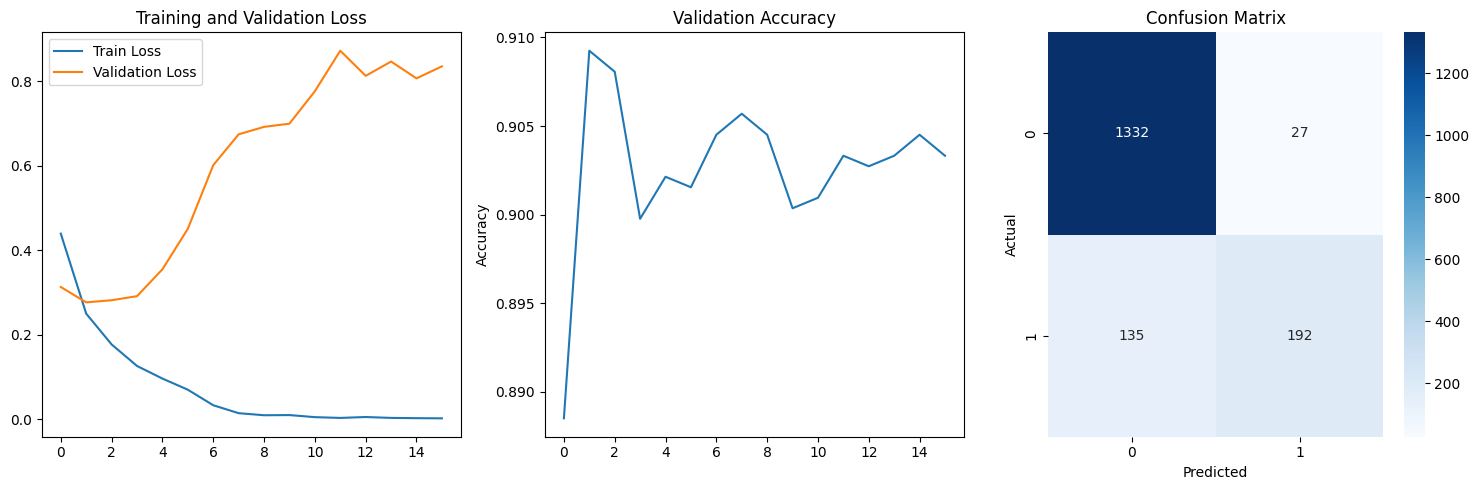


Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.98      0.94      1359
    Positive       0.88      0.59      0.70       327

    accuracy                           0.90      1686
   macro avg       0.89      0.78      0.82      1686
weighted avg       0.90      0.90      0.90      1686



In [ ]:
# Results
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))




In [ ]:
#vocab

from nltk.corpus import opinion_lexicon

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())


pos_count = 0
neg_count = 0
neutral_count = 0

for word, freq in vocab.items():
    if word.lower() in positive_words:
        pos_count += freq
    elif word.lower() in negative_words:
        neg_count += freq
    else:
        neutral_count += freq

print("Sentiment distribution:")
print(f"Positive: {pos_count}")
print(f"Negative: {neg_count}")
print(f"Neutral: {neutral_count}")

Sentiment distribution:
Positive: 423487
Negative: 668304
Neutral: 6024087


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
